In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Layer, Multiply, Reshape, Permute
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2`
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from google.colab import files

In [ ]:
# Install Kaggle library and prepare for dataset download
!pip install -q kaggle
!mkdir -p ~/.kaggle

# Upload Kaggle API key
files.upload()

# Download and unzip the dataset
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [ ]:
# Set data directory
data_dir = "/content"

# Load metadata
df_meta = pd.read_csv(os.path.join(data_dir, "HAM10000_metadata.csv"))

# Select only the required classes: 'df', 'vasc', 'akiec'
selected_classes = ['df', 'vasc', 'akiec']
df_meta = df_meta[df_meta['dx'].isin(selected_classes)].reset_index(drop=True)

# Collect all image paths from both directories
image_paths = glob('/content/HAM10000_images_part_1/*.jpg') + glob('/content/HAM10000_images_part_2/*.jpg')

# Create a dictionary mapping image IDs to their full paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(path))[0]: path
    for path in image_paths
}

# Map image paths to the metadata dataframe
df_meta['path'] = df_meta['image_id'].map(imageid_path_dict.get)

# Check for missing paths
if df_meta['path'].isnull().any():
    print("Some images are missing from the provided directories!")
    missing_ids = df_meta[df_meta['path'].isnull()]['image_id'].tolist()
    print(f"Missing image IDs: {missing_ids}")

# Map categorical labels to numeric values
label_mapping = {label: idx for idx, label in enumerate(selected_classes)}
df_meta['label'] = df_meta['dx'].map(label_mapping)

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df_meta, stratify=df_meta['label'], test_size=0.2, random_state=42)

# Augmentation parameters

In [ ]:
# Augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images
augmented_dir = os.path.join(data_dir, "augmented_images")
os.makedirs(augmented_dir, exist_ok=True)

def augment_and_save_images(df, imgs_to_generate=500):
    augmented_data = []

    for class_label in df['label'].unique():
        class_data = df[df['label'] == class_label]
        img_count = len(class_data)

        for i in range(imgs_to_generate):
            img_path = class_data.iloc[i % img_count]['path']
            img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            augmented_images = datagen.flow(img_array, batch_size=1)
            for aug_img in augmented_images:
                save_path = os.path.join(augmented_dir, f"{class_label}_{i}.jpg")
                tf.keras.preprocessing.image.save_img(save_path, aug_img[0])
                augmented_data.append((save_path, class_label))
                break

    return pd.DataFrame(augmented_data, columns=['path', 'label'])


In [ ]:
# Augment training data
augmented_train_df = augment_and_save_images(train_df)

# Combine augmented data with original training data
train_df_combined = pd.concat([train_df[['path', 'label']], augmented_train_df], ignore_index=True)

# Convert 'label' column to string
train_df_combined['label'] = train_df_combined['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)


In [ ]:
train_gen = datagen.flow_from_dataframe(
    train_df_combined,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # Changed target size to (224, 224)
    class_mode='categorical',
    batch_size=32
)

val_gen = ImageDataGenerator().flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # Changed target size to (224, 224)
    class_mode='categorical',
    batch_size=32
)


Found 1967 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Build model with ResNet50 base and attention mechanism
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

input_tensor = Input(shape=(224, 224, 3))
x = base_model(input_tensor)
x = GlobalAveragePooling2D()(x)
x = Reshape((1, x.shape[-1]))(x)
x = Attention()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_tensor = Dense(len(selected_classes), activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 2048)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 2048)           │         2,049 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,076 (91.99 MB)

 Trainable params: 527,364 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile the ResNet50 model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define model checkpoint to save the best model
checkpoint_path = os.path.join(data_dir, "resnet50_best_model.keras")
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Load training history
history_file = 'resnet50_train_history.pkl'

def load_history():
    try:
        with open(history_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Training parameters
total_epochs = 100
epochs_per_session = 100
initial_epoch = len(load_history()['accuracy'])

# Incremental training
while initial_epoch < total_epochs:
    print(f"\nStarting training from epoch {initial_epoch} to {initial_epoch + epochs_per_session}")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=initial_epoch + epochs_per_session,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint, reduce_lr]
    )

    prev_history = load_history()
    for key in history.history:
        if key in prev_history:
            prev_history[key].extend(history.history[key])
        else:
            prev_history[key] = history.history[key]

    with open(history_file, 'wb') as f:
        pickle.dump(prev_history, f)

    initial_epoch += epochs_per_session
    print(f"Completed {initial_epoch} epochs. Training progress saved.\n")

# Final evaluation
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Final Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Starting training from epoch 0 to 100
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8280 - loss: 0.9657
Epoch 1: val_loss improved from inf to 0.80117, saving model to /content/resnet50_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 631ms/step - accuracy: 0.8280 - loss: 0.9644 - val_accuracy: 0.8632 - val_loss: 0.8012 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8588 - loss: 0.6966
Epoch 2: val_loss improved from 0.80117 to 0.73246, saving model to /content/resnet50_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 471ms/step - accuracy: 0.8586 - loss: 0.6967 - val_accuracy: 0.8462 - val_loss: 0.7325 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8753 - loss: 0.6163
Epoch 3: val_loss improved from 0.73246 to 0.71009, saving model to /content/resnet50_best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 507ms/step - accuracy: 0.8753 - loss: 0.6161 - val_accuracy: 0.8547 - val_loss: 

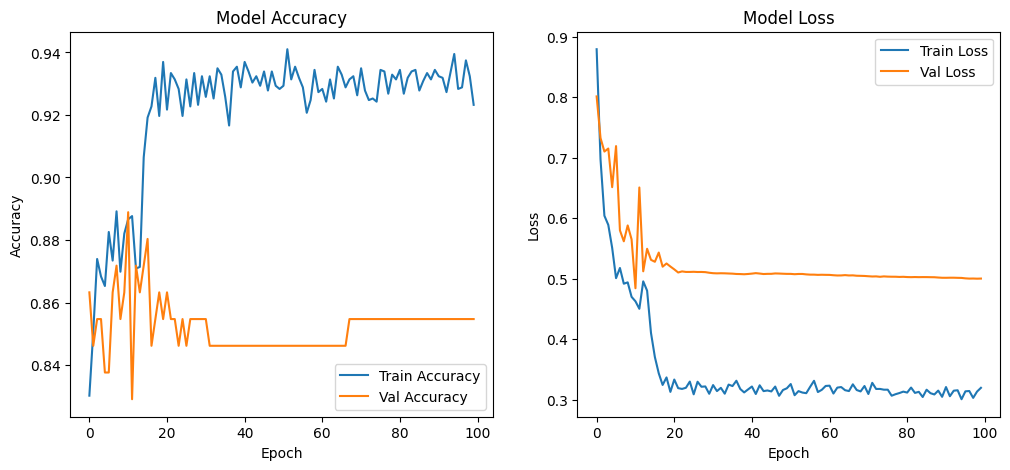

In [ ]:
# Plot the final history
with open(history_file, 'rb') as f:
    final_history = pickle.load(f)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['accuracy'], label='Train Accuracy')
plt.plot(final_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history['loss'], label='Train Loss')
plt.plot(final_history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()